In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.join(os.path.dirname(os.getcwd()), '')
sys.path.append(flicc_path)
import pandas as pd
from data import Preprocess
from models import Predict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(flicc_path+'Data/fallacy_test.csv')

In [3]:
def inverse_labelmap(y_pred, labelmap):
    # Invert the labelmap to create a reverse mapping
    reverse_labelmap = {v: k for k, v in labelmap.items()}
    string_labels = [reverse_labelmap[num] for num in y_pred]
    return string_labels

In [4]:
# Model 1:
data = Preprocess(df=df,model_checkpoint='bert-base-uncased',batch_size=32)
data.setup_dataloader()

model = Predict(load_dir='./model_output_1/model')
y_pred = model.predict(dataloader=data.dataloader)

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [5]:
df['model_1'] = inverse_labelmap(y_pred, {'bknow':0, 'struct':1})
bk = df[df['model_1'] == 'bknow'].copy()
st = df[df['model_1'] == 'struct'].copy()

In [6]:
# Model 2:
data = Preprocess(df=bk,model_checkpoint='bert-base-uncased',batch_size=32)
data.setup_dataloader()

model = Predict(load_dir='./model_output_2/model')
y_pred = model.predict(dataloader=data.dataloader)

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [7]:
bk['model_2']  = inverse_labelmap(y_pred, {'misrepresentation':0,'oversimplification':1,'slothful induction':2})

In [21]:
# Model 3:
data = Preprocess(df=st,model_checkpoint='roberta-large',batch_size=16)
data.setup_dataloader()

model = Predict(load_dir='./model_output_3/model')
y_pred = model.predict(dataloader=data.dataloader)

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [22]:
st['model_3'] = inverse_labelmap(y_pred, {'ad hominem':0,'anecdote':1,'cherry picking':2,'conspiracy theory':3,'fake experts':4,'false choice':5,'false equivalence':6,'impossible expectations':7,'single cause':8})

In [23]:
fa = df['model_1'].copy()
fa.loc[bk.index] = bk['model_2']
fa.loc[st.index] = st['model_3']
print(classification_report(y_true=df['label'], y_pred=fa, zero_division=0.0))

                         precision    recall  f1-score   support

             ad hominem       0.85      0.76      0.80        37
               anecdote       0.91      0.88      0.89        24
         cherry picking       0.61      0.61      0.61        31
      conspiracy theory       0.69      0.91      0.78        22
           fake experts       0.83      0.71      0.77         7
           false choice       0.31      0.57      0.40         7
      false equivalence       0.33      0.25      0.29         8
impossible expectations       0.68      0.81      0.74        21
      misrepresentation       0.62      0.59      0.60        22
     oversimplification       0.68      0.75      0.71        20
           single cause       0.73      0.75      0.74        32
     slothful induction       0.43      0.24      0.31        25

               accuracy                           0.68       256
              macro avg       0.64      0.65      0.64       256
           weighted avg

Text(0.5, 1.0, 'Normalized confusion matrix')

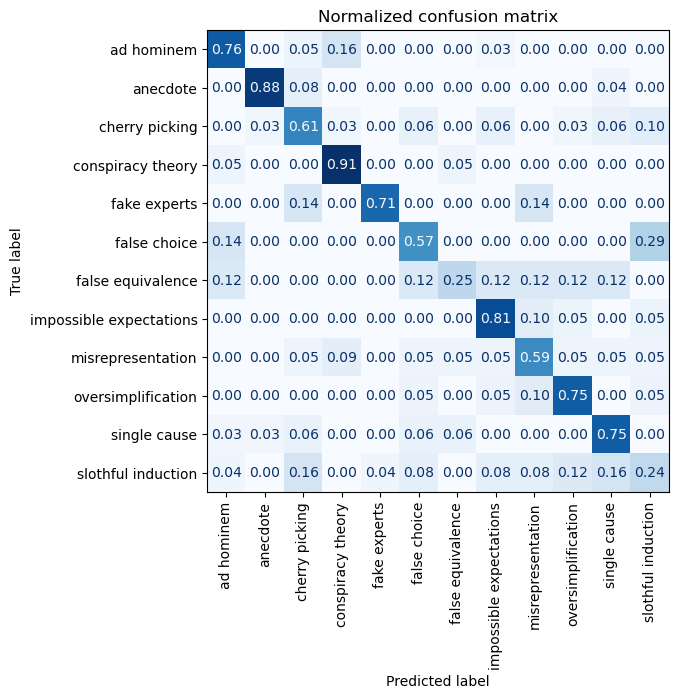

In [35]:
cm = confusion_matrix(y_true=df['label'], y_pred=fa, normalize='true')
_, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(fa.unique()))
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation='vertical')
plt.title("Normalized confusion matrix")